<a href="https://colab.research.google.com/github/hevertonvalerio/Challenge/blob/main/forecast_tickers_heverton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install pmdarima

In [74]:
## Preâmbulo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.api as qqplot
import random
import yfinance as yf
import os

# bibiotecas Time_series
import matplotlib.dates as mdates
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

import scipy.stats as stats

## importando também o pmdarima, para usar a função auto.arima, que pode otimizar nossos resultados c este tipo de série tempora
import pmdarima as pm

In [75]:
## Estilo do plot:

plt.style.use([ 'grayscale' , 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/tsp.mplstyle' ])

In [76]:
ativos = yf.download(['LMND'], start = '2024-01-02')
#ativos = yf.download(['NVAX', 'CCCC', 'TGI', 'LMND'], start = '2024-01-02')

[*********************100%***********************]  1 of 1 completed


In [77]:
ativos = ativos.stack(level=1)

IndexError: Too many levels: Index has only 1 level, not 2

In [ ]:
ativos = ativos['Adj Close']

In [ ]:
ativos.reset_index(inplace = True)

In [ ]:
ativos

In [ ]:
df = ativos.copy()
#df = pd.read_csv(ativos)


df.head()

df.set_index('Date', inplace= True)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')


df.head()

In [ ]:
## Importando Bitcoin; fazendo join em 'df'

bit_df = yf.download('BTC-USD', start = '2024-01-02')

bit_df = bit_df[['Close']].rename(columns = {'Close':'BTC'})

bit_df.index = pd.to_datetime(bit_df.index, format = '%Y-%m-%d')

df.index = pd.to_datetime(df.index)

df = df.merge(bit_df, left_index=True, right_index=True, how = 'left')

df.head()

In [ ]:
## Definindo o tsplot, como no livro:
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None,xlabel=None,set_major=None):

  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()

  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if xlabel is not None:
    ax.set_xlabel(xlabel)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))

  if label is not None:
    plt.legend()

  if set_major is not None:
    ax.xaxis.set_major_locator(set_major)
  plt.tight_layout()

  return

In [162]:
lmnd_df = df[['Adj Close']]
# lmnd_df = result.trend

lmnd_df.head()

,Adj Close
Date,
2024-01-02,17.040001
2024-01-03,16.219999
2024-01-04,16.610001
2024-01-05,16.549999
2024-01-08,18.250000


In [164]:
lmnd_df.tail(5)

,Adj Close
Date,
2024-10-07,15.650000
2024-10-08,15.730000
2024-10-09,16.350000
2024-10-10,16.920000
2024-10-11,17.389999


In [140]:
lmnd_df = lmnd_df.dropna()

In [141]:
lmnd_df.isna().sum()

0

In [ ]:
## plotando o ACF e a série original -- sem diferenciação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

tspplot(df['Adj Close'], label = 'LMND 2024', ax = ax1)

y = plot_acf(df['Adj Close'], title = 'ACF - LMND 2024', ax = ax2, lags = 20)

In [ ]:
## Fazendo o train-test split (10)

len_df = len(lmnd_df)
train_size = len_df - 10

#print(len_df)
#print(train_size)

train = lmnd_df.iloc[:train_size]
train.index = pd.to_datetime(train.index)
train = train.asfreq('B')

test = lmnd_df.iloc[train_size:]
test.index = pd.to_datetime(test.index)
test = test.asfreq('B')

print(train)
print(test)

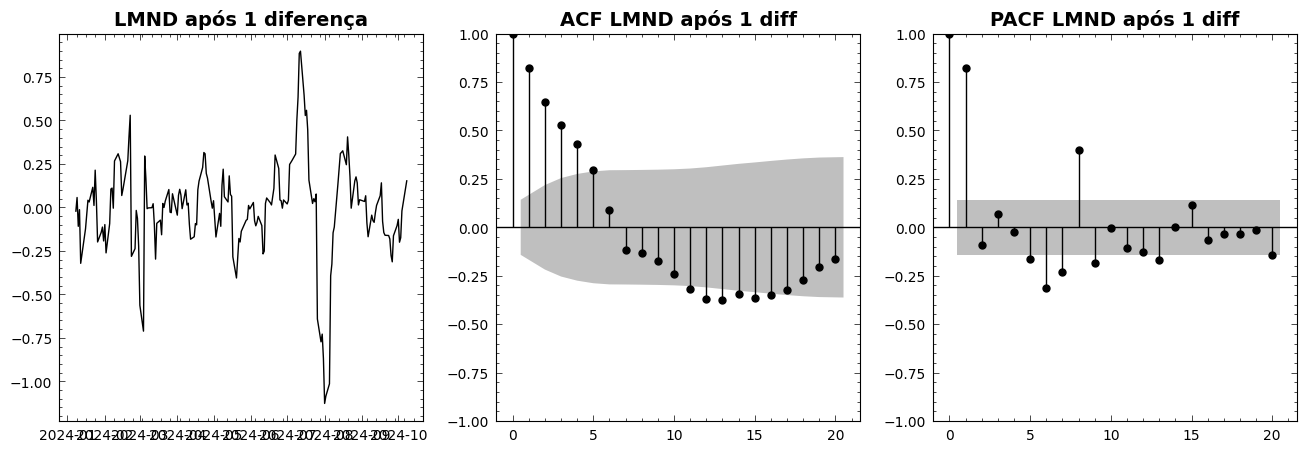

In [144]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

ax1.plot(lmnd_df.index, lmnd_df.diff(), linestyle = 'solid', alpha = 1, lw = 1)
ax1.set_title('LMND após 1 diferença')

y1 = plot_acf(lmnd_df.diff().dropna(), lags = 20, ax = ax2, title = 'ACF LMND após 1 diff')
y2 = plot_pacf(lmnd_df.diff().dropna(), lags = 20, ax = ax3, title = 'PACF LMND após 1 diff')

In [145]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(lmnd_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(lmnd_df.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

## É estacionário somente com diferenciação (p-value < 0.01)

ADF Statistic: -2.994471
p-value: 0.035414
ADF Statistic: -5.311875
p-value: 0.000005


In [146]:
## Testando a diferença entre otimizar sozinho e o Auto.arima
import itertools

for i, j in itertools.product(range(6), range(6)):
    print('AIC do ', 'ARIMA(',i,', 1, ', j,'):',
    round(ARIMA(train, order = (i, 1, j),
                    #freq = 'B',
                    enforce_stationarity = True,
                    enforce_invertibility = True).fit(method_kwargs = {'maxiter':700}).aic, 4))


AIC do  ARIMA( 0 , 1,  0 ): 458.6759
AIC do  ARIMA( 0 , 1,  1 ): 460.1608
AIC do  ARIMA( 0 , 1,  2 ): 459.997
AIC do  ARIMA( 0 , 1,  3 ): 461.9964
AIC do  ARIMA( 0 , 1,  4 ): 463.6401
AIC do  ARIMA( 0 , 1,  5 ): 463.8613
AIC do  ARIMA( 1 , 1,  0 ): 460.2777
AIC do  ARIMA( 1 , 1,  1 ): 461.1514
AIC do  ARIMA( 1 , 1,  2 ): 461.9967
AIC do  ARIMA( 1 , 1,  3 ): 463.8374
AIC do  ARIMA( 1 , 1,  4 ): 465.3184
AIC do  ARIMA( 1 , 1,  5 ): 465.726
AIC do  ARIMA( 2 , 1,  0 ): 459.8928
AIC do  ARIMA( 2 , 1,  1 ): 461.7789
AIC do  ARIMA( 2 , 1,  2 ): 461.7935
AIC do  ARIMA( 2 , 1,  3 ): 461.7535
AIC do  ARIMA( 2 , 1,  4 ): 462.7146
AIC do  ARIMA( 2 , 1,  5 ): 461.4275
AIC do  ARIMA( 3 , 1,  0 ): 461.6806
AIC do  ARIMA( 3 , 1,  1 ): 463.6472


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC do  ARIMA( 3 , 1,  2 ): 462.1811
AIC do  ARIMA( 3 , 1,  3 ): 463.6085
AIC do  ARIMA( 3 , 1,  4 ): 464.5685
AIC do  ARIMA( 3 , 1,  5 ): 463.0449
AIC do  ARIMA( 4 , 1,  0 ): 463.4422
AIC do  ARIMA( 4 , 1,  1 ): 465.0739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC do  ARIMA( 4 , 1,  2 ): 459.3322


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC do  ARIMA( 4 , 1,  3 ): 464.4357
AIC do  ARIMA( 4 , 1,  4 ): 464.6229
AIC do  ARIMA( 4 , 1,  5 ): 464.3828
AIC do  ARIMA( 5 , 1,  0 ): 463.7433
AIC do  ARIMA( 5 , 1,  1 ): 465.5314
AIC do  ARIMA( 5 , 1,  2 ): 461.237


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


AIC do  ARIMA( 5 , 1,  3 ): 468.3678


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


AIC do  ARIMA( 5 , 1,  4 ): 458.5007


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC do  ARIMA( 5 , 1,  5 ): 458.3834


Melhor modelo: AIC do  ARIMA( 2 , 1,  3)

In [155]:
## Modelo

model = ARIMA(train, order = (5,1,4))
print(model.fit().summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  194
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -219.869
Date:                Sat, 12 Oct 2024   AIC                            459.737
Time:                        01:12:34   BIC                            492.364
Sample:                    01-02-2024   HQIC                           472.950
                         - 09-27-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5108      0.667     -0.766      0.444      -1.818       0.796
ar.L2         -0.2143      0.135     -1.591      0.112      -0.478       0.050
ar.L3          0.6105      0.249      2.455      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


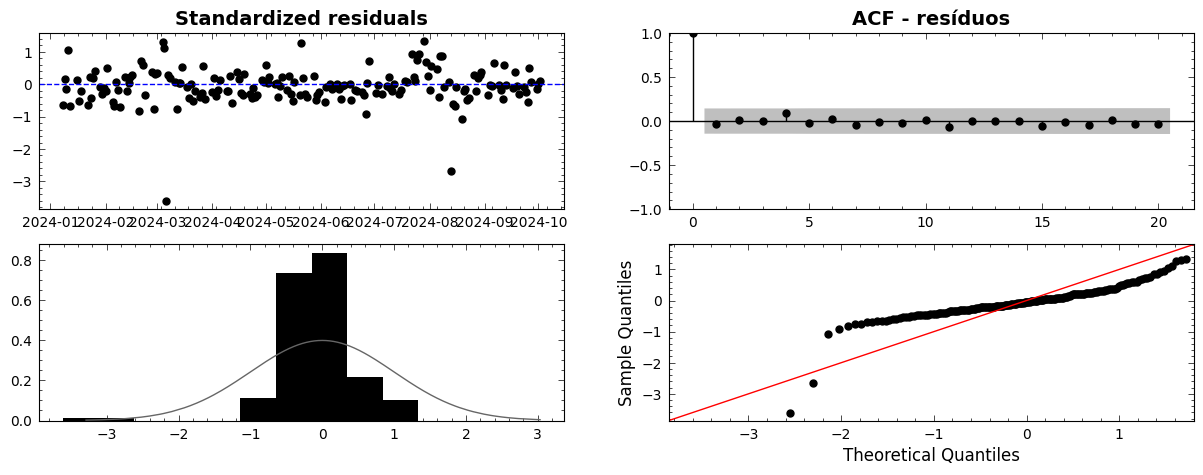

In [156]:
## Resíduos

res = model.fit()
res_standard = (res.resid - res.resid.mean()) / np.sqrt(res.resid.var()) # standardized residuals
ts = lmnd_df

fig,axs = plt.subplots(2, 2,figsize=(14,5))

axs[0,0].scatter(ts.index[1:train_size], res_standard[1:train_size])
axs[0,0].axhline(y=0, color='b', linestyle='--')
axs[0,0].set_title('Standardized residuals')

x = plot_acf(res.resid.dropna(), lags=20, ax=axs[0,1], title="ACF - resíduos")

axs[1,0].hist(res_standard[1:train_size], density=True)
x = np.sort(np.random.normal(0, 1, 1000))
axs[1,0].plot(x, stats.norm.pdf(x, 0, 1))
x1 = sm.qqplot(res_standard[1:train_size], line ='45', ax=axs[1,1])

<Axes: xlabel='Date'>

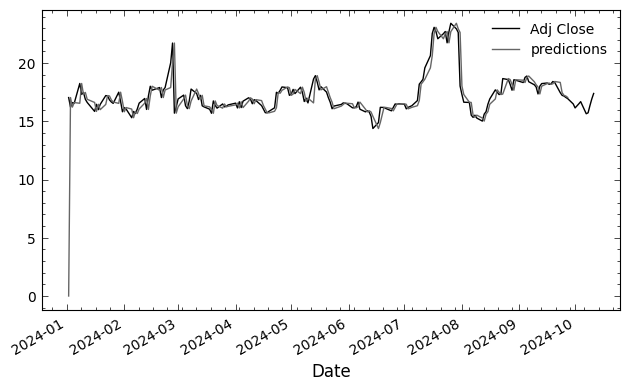

In [149]:
## Fazendo o predict; bom ajuste apesar de tudo!

predict = model.fit().predict()

df_predict = df[['Adj Close']].copy()
df_predict['predictions'] = pd.DataFrame(predict)

df_predict.plot()

In [150]:
t = int(len(lmnd_df)-train_size)

forecast = model.fit().get_forecast(t)
forecast.predicted_mean

# Previsões com intervalos de confiança de 95%
fc_series = pd.Series(forecast.predicted_mean, index=test.index)

In [151]:
df_prev = pd.DataFrame({"Previsões":fc_series})


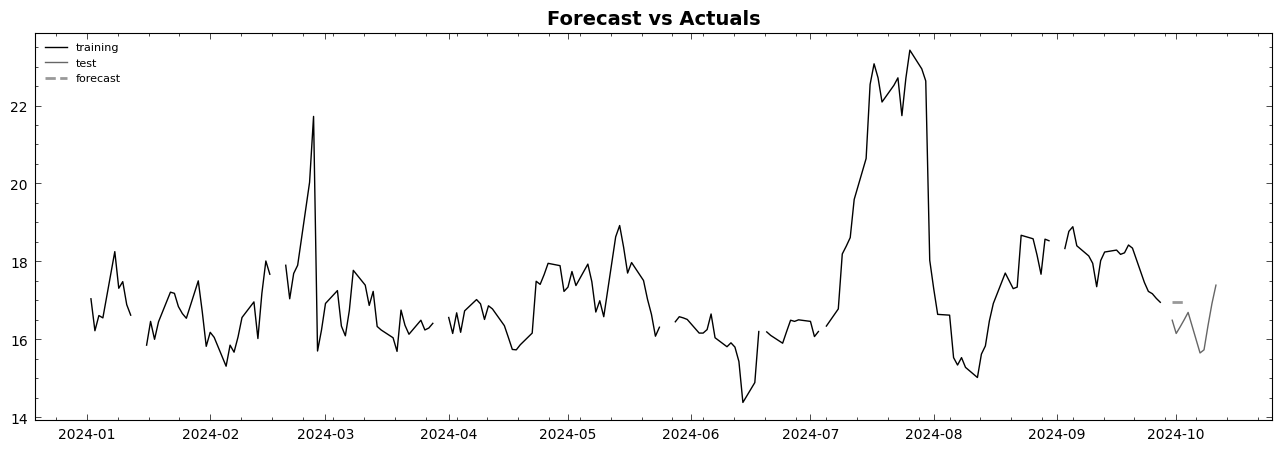

In [152]:
## Gráfico comparando train e test

plt.figure(figsize=(15,5))

plt.plot(train, label='training',linestyle='solid',alpha=1,lw=1)
plt.plot(test, label='test',linestyle='solid',alpha=1,lw=1)
plt.plot(fc_series, label='forecast',linestyle='dashed',alpha=1,lw=2)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()

---


In [96]:
import pandas as pd

In [92]:
def tspdecompose(df,model='additive',title=None):
  from statsmodels.tsa.seasonal import seasonal_decompose

  decomp = seasonal_decompose(df, model='multiplicative')

  fig = decomp.plot()
  fig.set_size_inches((9, 7))

  if title is not None:
    plt.suptitle(title,y=1.05)

  plt.tight_layout()
  plt.show()

  return

In [95]:
tspdecompose(lmnd_df,model='additive',title='LMND')

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [117]:
def tspdecompose(df,model='additive',title=None, period=None): # Add period argument
  from statsmodels.tsa.seasonal import seasonal_decompose

  # Infer frequency if not provided
  if period is None and isinstance(df.index, pd.DatetimeIndex) and df.index.freq is None:
    period = pd.infer_freq(df.index)
    print(f"Inferred frequency: {period}") # Print inferred frequency

  # If period is still None and it's a DatetimeIndex, try to infer with rule
  if period is None and isinstance(df.index, pd.DatetimeIndex):
    period = pd.infer_freq(df.index, warn=True)
    print(f"Inferred frequency using 'rule': {period}") # Print inferred frequency


  decomp = seasonal_decompose(df, model='multiplicative', period=period) # Pass period to seasonal_decompose

  fig = decomp.plot()
  fig.set_size_inches((9, 7))

  if title is not None:
    plt.suptitle(title,y=1.05)

  plt.tight_layout()
  plt.show()

  return

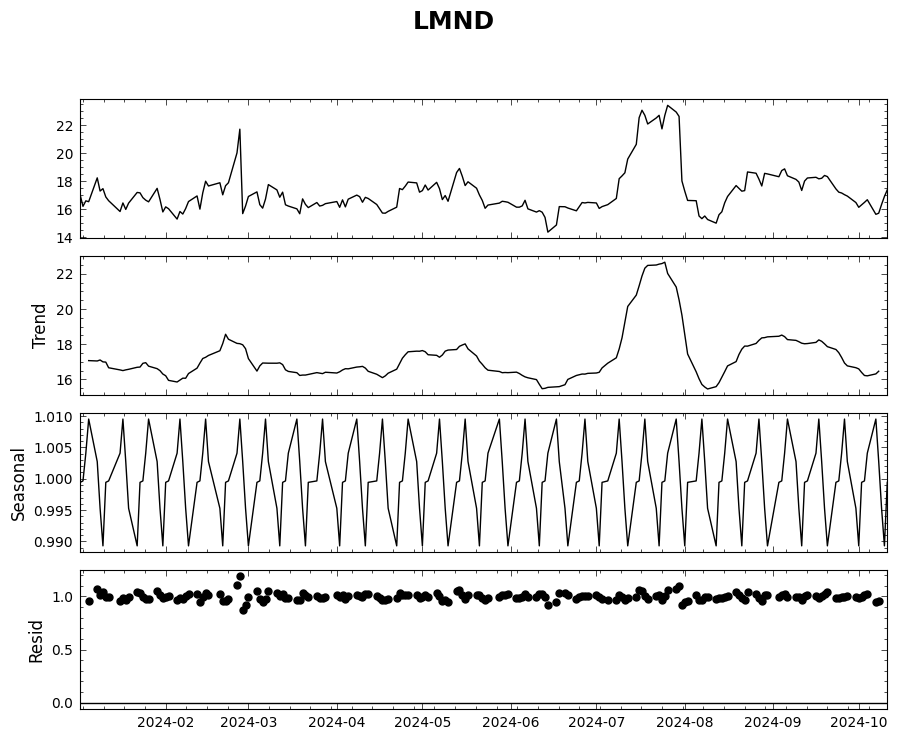

In [118]:
#tspdecompose(lmnd_df, model='additive', title='LMND') # Tries to infer the period

   # Or, specify the period explicitly if known:
tspdecompose(lmnd_df, model='additive', title='LMND', period=7) # For weekly data, for example

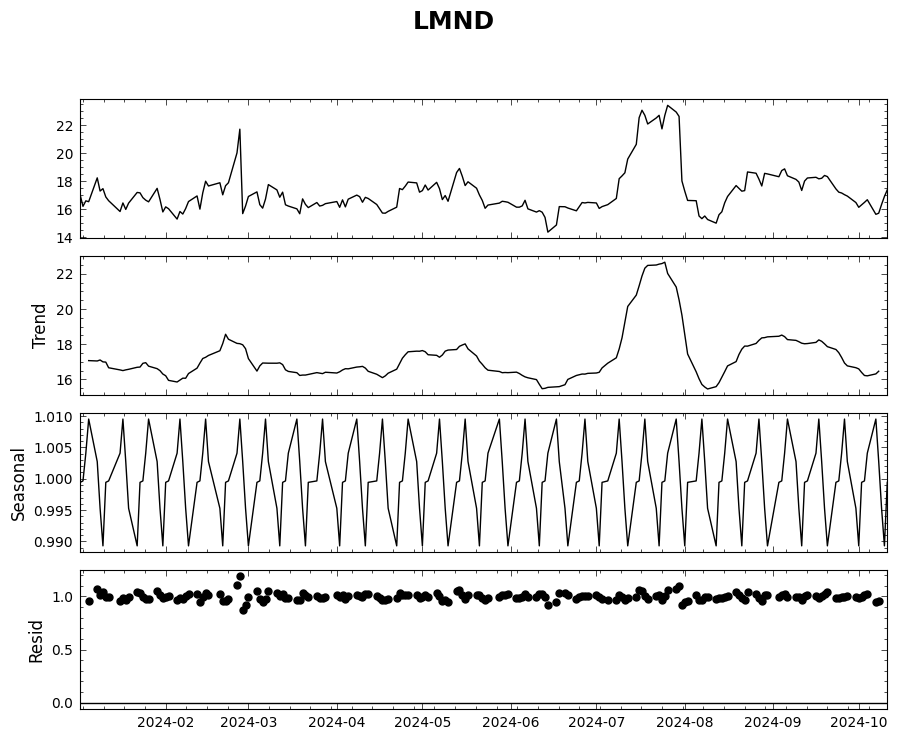

AttributeError: 'NoneType' object has no attribute 'trend'

In [120]:
tspdecompose(lmnd_df, model='additive', title='LMND', period=7).trend

In [107]:
trend

NameError: name 'trend' is not defined

In [108]:
decompose_result.trend

NameError: name 'decompose_result' is not defined

In [119]:
decomp.trend

NameError: name 'decomp' is not defined

Trend: 0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.011909
7    -0.028002
8    -0.042169
9    -0.017565
10    0.023187
11    0.042622
12    0.022870
13   -0.017908
14   -0.042222
15   -0.027717
16    0.012271
17    0.040977
18    0.032009
19   -0.006388
20   -0.038912
21   -0.035660
22    0.000377
23    0.036068
24    0.038598
25    0.005641
26   -0.032502
27   -0.040763
28   -0.011547
29    0.028286
30    0.042112
31    0.017221
32   -0.023503
33   -0.042618
34   -0.022551
35    0.018250
36    0.042272
37    0.027429
38   -0.012632
39   -0.041079
40   -0.031758
41    0.006761
42    0.039064
43    0.035452
44         NaN
45         NaN
46         NaN
47         NaN
48         NaN
49         NaN
Name: trend, dtype: float64
Seasonal: 0    -0.864892
1    -0.142630
2     0.693295
3     0.874337
4     0.234048
5    -0.638894
6    -0.784015
7    -0.130810
8     0.833769
9     0.762508
10   -0.027270
11   -0.809446
12   -0.864892
13   -0.14

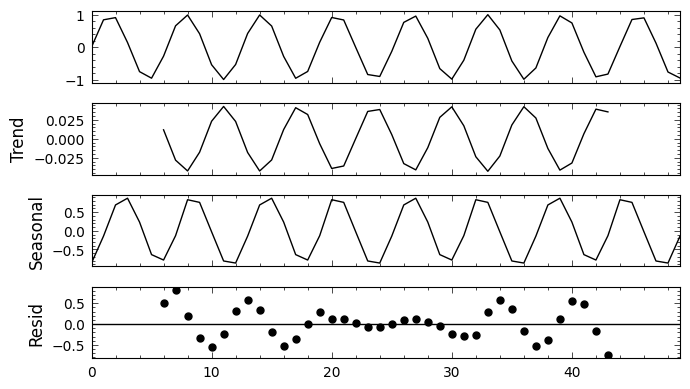

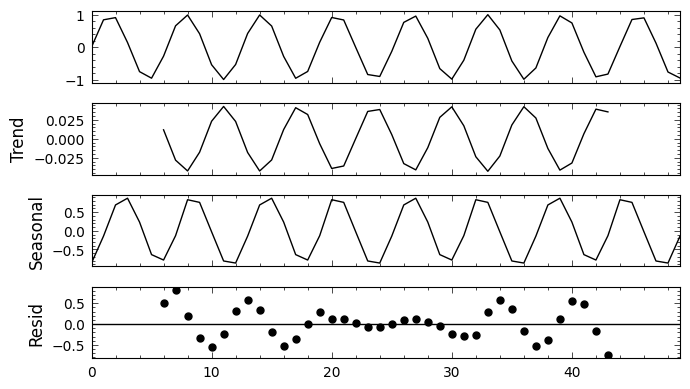

In [110]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Série temporal fictícia
#data = pd.Series([np.sin(i) for i in range(50)])

# Decompondo a série
result = seasonal_decompose(lmnd_df, model='additive', period=7)

# Acessando os componentes
print("Trend:", result.trend)
print("Seasonal:", result.seasonal)
print("Residual:", result.resid)

# Plotando os componentes
result.plot()



def tspdecompose(df,model='additive',title=None, period=None): # Add period argument
  from statsmodels.tsa.seasonal import seasonal_decompose

  # Infer frequency if not provided
  if period is None and isinstance(df.index, pd.DatetimeIndex) and df.index.freq is None:
    period = pd.infer_freq(df.index)
    print(f"Inferred frequency: {period}") # Print inferred frequency

  # If period is still None and it's a DatetimeIndex, try to infer with rule
  if period is None and isinstance(df.index, pd.DatetimeIndex):
    period = pd.infer_freq(df.index, warn=True)
    print(f"Inferred frequency using 'rule': {period}") # Print inferred frequency


  decomp = seasonal_decompose(df, model='multiplicative', period=period) # Pass period to seasonal_decompose

  fig = decomp.plot()
  fig.set_size_inches((9, 7))

  if title is not None:
    plt.suptitle(title,y=1.05)

  plt.tight_layout()
  plt.show()

  return


  tspdecompose(lmnd_df, model='additive', title='LMND', period=7).trend


In [111]:
print("Trend:", result.trend)


Trend: 0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.011909
7    -0.028002
8    -0.042169
9    -0.017565
10    0.023187
11    0.042622
12    0.022870
13   -0.017908
14   -0.042222
15   -0.027717
16    0.012271
17    0.040977
18    0.032009
19   -0.006388
20   -0.038912
21   -0.035660
22    0.000377
23    0.036068
24    0.038598
25    0.005641
26   -0.032502
27   -0.040763
28   -0.011547
29    0.028286
30    0.042112
31    0.017221
32   -0.023503
33   -0.042618
34   -0.022551
35    0.018250
36    0.042272
37    0.027429
38   -0.012632
39   -0.041079
40   -0.031758
41    0.006761
42    0.039064
43    0.035452
44         NaN
45         NaN
46         NaN
47         NaN
48         NaN
49         NaN
Name: trend, dtype: float64


Trend: Date
2024-01-02          NaN
2024-01-03          NaN
2024-01-04          NaN
2024-01-05    17.065714
2024-01-08    17.044285
                ...    
2024-10-07    16.308571
2024-10-08    16.461429
2024-10-09          NaN
2024-10-10          NaN
2024-10-11          NaN
Name: trend, Length: 197, dtype: float64
Seasonal: Date
2024-01-02   -0.030321
2024-01-03    0.001531
2024-01-04    0.099574
2024-01-05    0.183381
2024-01-08    0.044095
                ...   
2024-10-07    0.183381
2024-10-08    0.044095
2024-10-09   -0.100956
2024-10-10   -0.197305
2024-10-11   -0.030321
Name: seasonal, Length: 197, dtype: float64
Residual: Date
2024-01-02         NaN
2024-01-03         NaN
2024-01-04         NaN
2024-01-05   -0.699096
2024-01-08    1.161619
                ...   
2024-10-07   -0.841953
2024-10-08   -0.775524
2024-10-09         NaN
2024-10-10         NaN
2024-10-11         NaN
Name: resid, Length: 197, dtype: float64


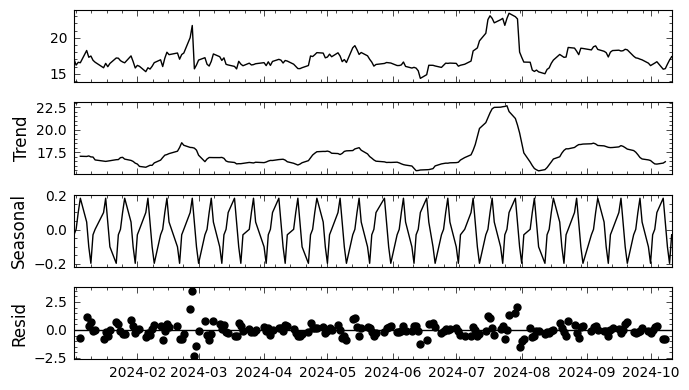

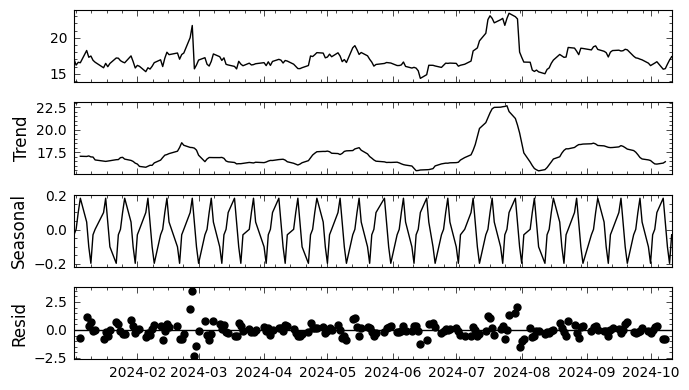

In [128]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Série temporal fictícia
#data = pd.Series([np.sin(i) for i in range(50)])

# Decompondo a série
result = seasonal_decompose(lmnd_df, model='additive', period=7)

# Acessando os componentes
print("Trend:", result.trend)
print("Seasonal:", result.seasonal)
print("Residual:", result.resid)

# Plotando os componentes
result.plot()

In [131]:
result.trend.plot()

AttributeError: 'DecomposeResult' object has no attribute 'lmnd_df'

<Axes: xlabel='Date'>

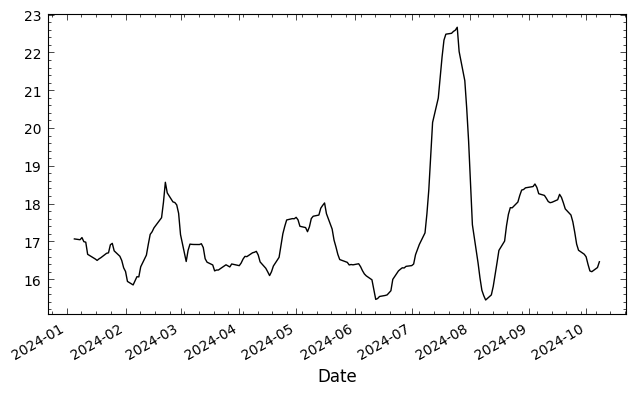

In [130]:
result.trend.plot()

----


#LSTM

In [157]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [159]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [166]:
lmnd_df.head()

,Adj Close
Date,
2024-01-02,17.040001
2024-01-03,16.219999
2024-01-04,16.610001
2024-01-05,16.549999
2024-01-08,18.250000


In [170]:
lmnd_df.rename(columns={'Adj Close': 'price'}, inplace=True)

<ipython-input-170-0a5a2372e092>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmnd_df.rename(columns={'Adj Close': 'price'}, inplace=True)


In [171]:
lmnd_df

,price
Date,
2024-01-02,17.040001
2024-01-03,16.219999
2024-01-04,16.610001
2024-01-05,16.549999
2024-01-08,18.250000
...,...
2024-10-07,15.650000
2024-10-08,15.730000
2024-10-09,16.350000


In [ ]:
# Carregue os dados em um DataFrame
df = pd.read_csv('seu_arquivo.csv', parse_dates=['data_coluna'], index_col='data_coluna')

# Visualize os primeiros registros
print(df.head())


In [ ]:
df = df.sort_index()

In [172]:
# Normalize os valores da série temporal para que estejam no intervalo [0, 1]. Isso ajuda a melhorar o desempenho do LSTM:

scaler = MinMaxScaler(feature_range=(0, 1))
df['valor_normalizado'] = scaler.fit_transform(lmnd_df['price'])

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [173]:
# Normalize os valores da série temporal para que estejam no intervalo [0, 1]. Isso ajuda a melhorar o desempenho do LSTM:

scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape the 'price' column to a 2D array using .values.reshape(-1, 1)
df['valor_normalizado'] = scaler.fit_transform(lmnd_df['price'].values.reshape(-1, 1))

In [174]:
#Para treinar um modelo LSTM, você precisa transformar a série temporal em um formato de sequência. Isso é feito criando "janelas" de tempo, onde cada janela é um conjunto de valores passados usados para prever o próximo valor.
#Defina o número de lag (passos anteriores a serem usados para prever o próximo valor) e crie sequências:

def criar_sequencias(dados, lag=5):
    X = []
    y = []
    for i in range(len(dados) - lag):
        X.append(dados[i:i + lag])
        y.append(dados[i + lag])
    return np.array(X), np.array(y)

# Preparar os dados de entrada (X) e saída (y)
lag = 5  # Use os 5 valores anteriores para prever o próximo
valores_normalizados = df['valor_normalizado'].values
X, y = criar_sequencias(valores_normalizados, lag)


In [175]:
X = X.reshape((X.shape[0], X.shape[1], 1))  # Aqui, 1 é o número de características (n_features)


In [176]:
# Dividir em 80% para treinamento e 20% para teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [177]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lag, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [178]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 0.1119 - val_loss: 0.0741
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0673 - val_loss: 0.0272
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0360 - val_loss: 0.0058
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0251 - val_loss: 0.0114
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0280 - val_loss: 0.0062
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0203 - val_loss: 0.0070
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0212 - val_loss: 0.0081
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0232 - val_loss: 0.0067
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0207 - val_loss: 0.0054
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0219 - val_loss: 0.0053
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0217 - val_loss: 0.0056
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0171 - val_loss: 0.0059


In [179]:
# Fazer previsões
y_pred = model.predict(X_test)

# Reverter a normalização
y_pred_inverso = scaler.inverse_transform(y_pred)
y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step


In [180]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_inverso, y_pred_inverso))
print(f'RMSE: {rmse}')


RMSE: 0.6835362102105055


In [181]:
# Fazer previsões com os dados de teste
y_pred = model.predict(X_test)

# Reverter a normalização para os valores originais
y_pred_inverso = scaler.inverse_transform(y_pred)
y_test_inverso = scaler.inverse_transform(y_test.reshape(-1, 1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


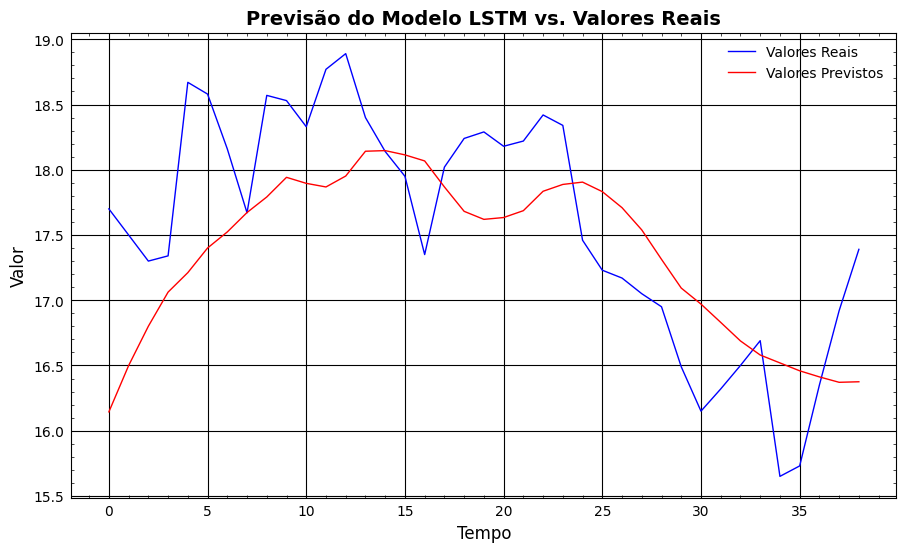

In [182]:
# Criar um gráfico com os valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverso, label='Valores Reais', color='blue')
plt.plot(y_pred_inverso, label='Valores Previstos', color='red')
plt.title('Previsão do Modelo LSTM vs. Valores Reais')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


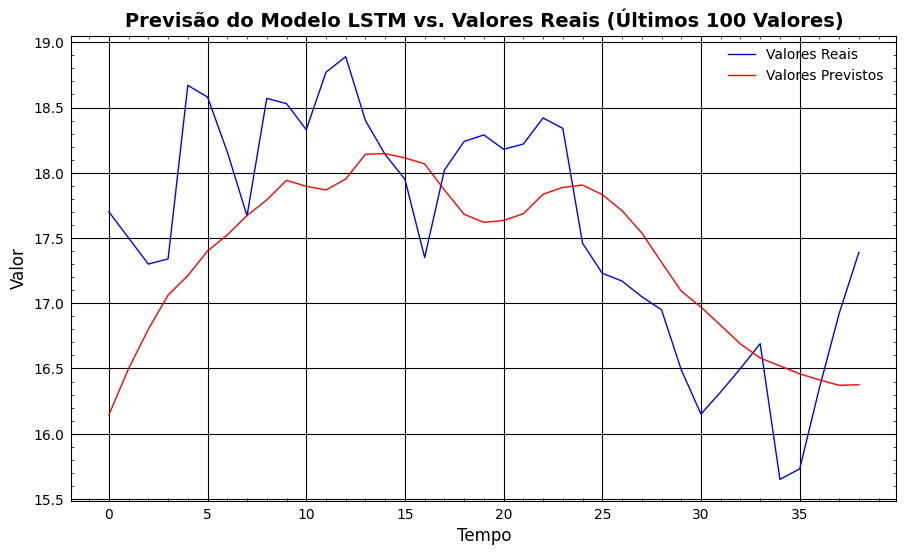

In [183]:
# Visualizar os últimos 100 valores para uma análise mais detalhada
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverso[-100:], label='Valores Reais', color='blue')
plt.plot(y_pred_inverso[-100:], label='Valores Previstos', color='red')
plt.title('Previsão do Modelo LSTM vs. Valores Reais (Últimos 100 Valores)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


In [185]:
# Vamos supor que você tenha usado n_steps=60 para treinar o modelo
n_steps = 60

# Pegue os últimos 60 dias do conjunto de dados (ou seja, do conjunto de treinamento/teste)
ultimo_batch = lmnd_df[-n_steps:]


In [186]:
# Redimensionar para 3D (1, n_steps, 1) - 1 amostra, 60 timesteps, 1 feature
ultimo_batch = ultimo_batch.reshape(1, n_steps, 1)

# Normalizar os dados usando o mesmo scaler que foi utilizado anteriormente
ultimo_batch_normalizado = scaler.transform(ultimo_batch.reshape(-1, 1))
ultimo_batch_normalizado = ultimo_batch_normalizado.reshape(1, n_steps, 1)


AttributeError: 'DataFrame' object has no attribute 'reshape'